In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import librosa

# --- Model and evaluation imports ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = "/content/drive/MyDrive/archive"

Mounted at /content/drive


In [ ]:
def load_data(dataset_path):
    features, labels = [], []
    emotions = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
    for actor_folder in tqdm(os.listdir(dataset_path), desc="Processing Actors"):
        if actor_folder.startswith("Actor_"):
            for file_name in os.listdir(os.path.join(dataset_path, actor_folder)):
                try:
                    emotion = emotions[file_name.split("-")[2]]
                    y, sr = librosa.load(os.path.join(dataset_path, actor_folder, file_name), sr=None)
                    mfccs = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
                    features.append(mfccs)
                    labels.append(emotion)
                except Exception:
                    continue
    return np.array(features), np.array(labels)

# --- 1. Load or Extract Features ---
DATASET_PATH = "/content/drive/MyDrive/archive"
features_file = 'extracted_features.npy'
labels_file = 'extracted_labels.npy'

if os.path.exists(features_file) and os.path.exists(labels_file):
    print("Loading features from saved files...")
    features = np.load(features_file, allow_pickle=True)
    labels = np.load(labels_file, allow_pickle=True)
else:
    print("Extracting features from audio files...")
    features, labels = load_data(DATASET_PATH)
    np.save(features_file, features)
    np.save(labels_file, labels)

Extracting features from audio files...


Processing Actors: 100%|██████████| 25/25 [13:17<00:00, 31.89s/it]


In [ ]:
# --- 2. Split and Scale the Data ---
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.25, random_state=42, stratify=labels)

# IMPORTANT: Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
print("Data scaled successfully.")

Data scaled successfully.


In [ ]:
# --- 3. Train and Evaluate Multiple Models ---
models = {
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
    print(f"Accuracy for {name}: {accuracy*100:.2f}%")

Training Random Forest...
Accuracy for Random Forest: 65.56%
Training SVM...
Accuracy for SVM: 57.02%
Training MLP...
Accuracy for MLP: 69.70%


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


/tmp/ipython-input-201293977.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")


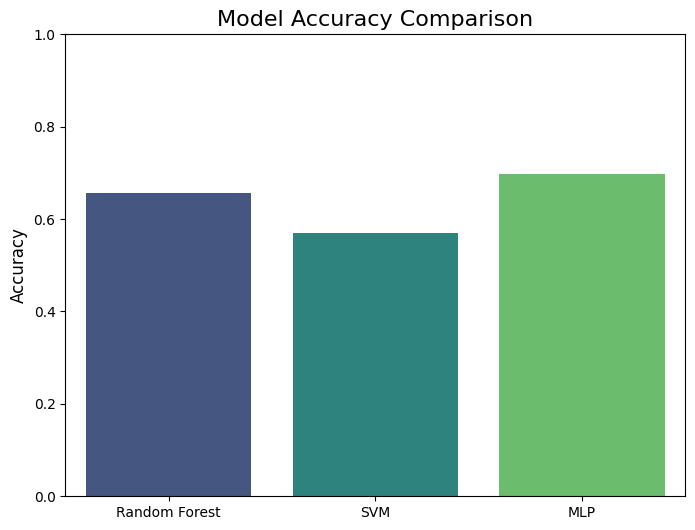

In [ ]:
# --- 4. Visualizations ---

## Plot 1: Model Accuracy Comparison
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

plt.figure(figsize=(8, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.title('Model Accuracy Comparison', fontsize=16)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.0)
plt.show()



--- Results for the best model: MLP ---


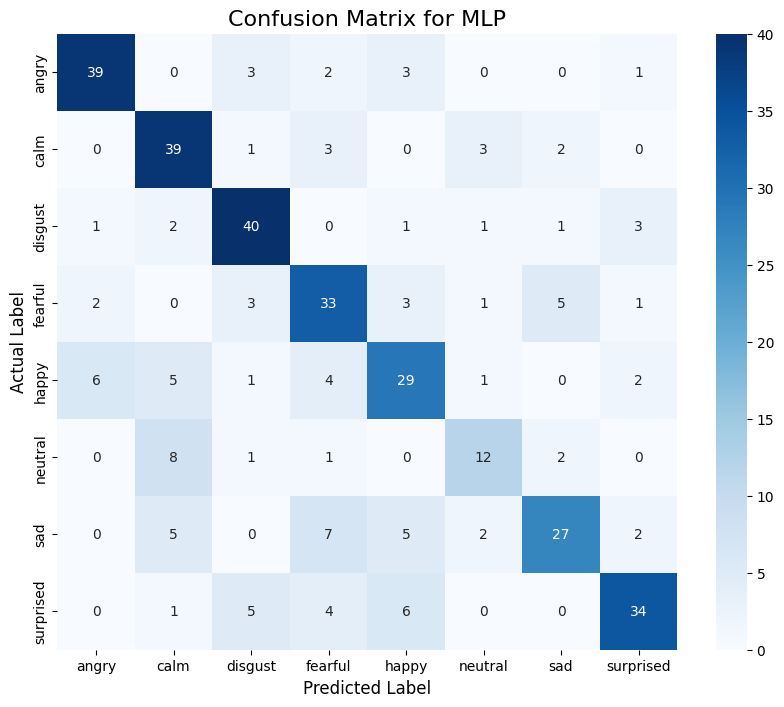

In [ ]:
## Plot 2: Confusion Matrix for the Best Model
print(f"\n--- Results for the best model: {best_model_name} ---")
y_pred_best = best_model.predict(X_test)
unique_labels = sorted(list(set(labels)))
conf_matrix = confusion_matrix(y_test, y_pred_best, labels=unique_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_labels, yticklabels=unique_labels)
plt.title(f'Confusion Matrix for {best_model_name}', fontsize=16)
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.show()


In [ ]:
## Visualization 3: Classification Report
# This report shows precision, recall, and F1-score for each emotion.
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=unique_labels))


Classification Report:
              precision    recall  f1-score   support

       angry       0.81      0.81      0.81        48
        calm       0.65      0.81      0.72        48
     disgust       0.74      0.82      0.78        49
     fearful       0.61      0.69      0.65        48
       happy       0.62      0.60      0.61        48
     neutral       0.60      0.50      0.55        24
         sad       0.73      0.56      0.64        48
   surprised       0.79      0.68      0.73        50

    accuracy                           0.70       363
   macro avg       0.69      0.68      0.69       363
weighted avg       0.70      0.70      0.69       363

